In [1]:
# %config Completer.use_jedi=False

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import DataLoader, Dataset


In [3]:
import gc
import numpy as np
import pandas as pd
import time
import random
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
pd.options.display.width = 1200
pd.options.display.max_colwidth = 1000

In [5]:
from itertools import chain
from collections import Counter,OrderedDict
import re
import string
import time
import os
from datetime import datetime

In [6]:
from torch.utils.tensorboard import SummaryWriter

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device.type.upper()} device')

Using CPU device


In [8]:
# random seeds
SEED = 22
torch.backends.cudnn.deterministic = True
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [9]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 170 kB 50.8 MB/s 
     |████████████████████████████████| 97 kB 4.4 MB/s 
     |████████████████████████████████| 133 kB 53.3 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=05f9d98888fc28025518fa6166a2257a2ed0b032ce92a6fe9a55e56911d4d472
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=8ba627d3bfa14e6aa56563f0850ac871b020bfe11811866299558437e7f0df0d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [10]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [11]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Mount drive for colab

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
cd /content/drive/MyDrive/PyTorch

/content/drive/MyDrive/PyTorch


# Data 

In [14]:
train_data, valid_data, test_data = torchtext.datasets.Multi30k()

In [15]:
dataset_train = torchtext.data.to_map_style_dataset(train_data)
dataset_test = torchtext.data.to_map_style_dataset(test_data)
dataset_valid = torchtext.data.to_map_style_dataset(valid_data)

In [16]:
SRC = 'German'
TRG = 'English'
FILE_SUFFIX = 'en-de'
SRC_LANG = 'de'
TRG_LANG = 'en'

In [17]:
# SRC = 'Telugu'
# TRG = 'English'
# FILE_SUFFIX = 'en-te'
# SRC_LANG = 'te'
# TRG_LANG = 'en'

In [46]:
src_train_tokens = []
trg_train_tokens = []
for a, b in dataset_train:
    src_train_tokens.append(a.split())
    trg_train_tokens.append(b.split())

In [47]:
src_train_tokens = list(chain.from_iterable(src_train_tokens))
trg_train_tokens = list(chain.from_iterable(trg_train_tokens))

In [48]:
# Fix bug in torchtext.vocab.build_vocab_from_iterator
def build_vocab_from_iterator_N(iterator, min_freq = 1, specials = None, special_first = True):
    """
    Build a Vocab from an iterator.

    Args:
        iterator: Iterator used to build Vocab. Must yield list or iterator of tokens.
        min_freq: The minimum frequency needed to include a token in the vocabulary.
        specials: Special symbols to add. The order of supplied tokens will be preserved.
        special_first: Indicates whether to insert symbols at the beginning or at the end.


    Returns:
        torchtext.vocab.Vocab: A `Vocab` object

    Examples:
        >>> #generating vocab from text file
        >>> import io
        >>> from torchtext.vocab import build_vocab_from_iterator
        >>> def yield_tokens(file_path):
        >>>     with io.open(file_path, encoding = 'utf-8') as f:
        >>>         for line in f:
        >>>             yield line.strip().split()
        >>> vocab = build_vocab_from_iterator(yield_tokens_batch(file_path), specials=["<unk>"])
    """

    counter = Counter()
    for tokens in iterator:
        counter.update([tokens]) # Added brackets. otherwise characters will be updated insted of words

    if specials is not None:
        for tok in specials:
            del counter[tok]

    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[0])
    sorted_by_freq_tuples.sort(key=lambda x: x[1], reverse=True)
    ordered_dict = OrderedDict(sorted_by_freq_tuples)

    if specials is not None:
        if special_first:
            specials = specials[::-1]
        for symbol in specials:
            ordered_dict.update({symbol: min_freq})
            ordered_dict.move_to_end(symbol, last=not special_first)

    word_vocab = torchtext.vocab.vocab(ordered_dict, min_freq=min_freq)
    return word_vocab

In [49]:
MIN_FREQ = 2
vocab_src = build_vocab_from_iterator_N(src_train_tokens, min_freq=MIN_FREQ, specials=['<pad>','<unk>', '<bos>', '<eos>'], special_first=True)
vocab_trg = build_vocab_from_iterator_N(trg_train_tokens, min_freq=MIN_FREQ, specials=['<pad>','<unk>', '<bos>', '<eos>'], special_first=True)

In [50]:
vocab_src.set_default_index(vocab_src['<unk>'])
vocab_trg.set_default_index(vocab_trg['<unk>'])

In [51]:
len(vocab_src), len(vocab_trg)

(9762, 7964)

In [24]:
# vocab_src.vocab.lookup_tokens(dataset_train[0][0].split())

In [25]:
v_t = vocab_trg.get_itos()
v_s = vocab_src.get_itos()

In [26]:
# Function to perform padding

# pad_indx = vocab_src.word2indx['<pad>']
pad_indx = vocab_src['<pad>']

def collate_by_padding(batch):
    inputs = [None]*len(batch)
    targets = [None]*len(batch)
    inputs_len = [None]*len(batch)
    targets_len = [None]*len(batch)

    for i,(inp, targ) in enumerate(tuple(batch)):
        inp = vocab_src(inp.split()+['<eos>'])
        targ = vocab_trg(['<bos>']+targ.split()+['<eos>'])
        inputs[i] = torch.IntTensor(inp)
        targets[i] = torch.IntTensor(targ)
        
        inputs_len[i] = len(inp)
        targets_len[i] = len(targ)
        

    max_length_inputs = max(inputs_len)
    max_length_targets = max(targets_len)
    
    for i in range(len(batch)):
        inputs[i] = torch.cat((inputs[i], torch.IntTensor([pad_indx]*(max_length_inputs - inputs_len[i]))), dim=-1)
        targets[i] = torch.cat((targets[i], torch.IntTensor([pad_indx]*(max_length_targets - targets_len[i]))), dim=-1)
        
    return torch.stack(inputs), torch.stack(targets)
    

In [45]:
len(vocab_src), len(vocab_trg)

(9762, 7964)

# Model

Implemnetation of the transformer architecture as detailed in "Attention Is All You Need" by Vaswani et al

In [28]:
NEG_INF = -1e9

In [29]:
class Attention(nn.Module):
    '''
    Scaled dot-product attention 
    '''
    def __init__(self, projection_size_qk, projection_size_v, model_dim):
        super(Attention, self).__init__()
        self.d_k = projection_size_qk
        self.d_v = projection_size_v
        self.d_model = model_dim
#         self.projection_matrix_Q = torch.nn.Parameter(torch.rand(self.d_model, self.d_k))
#         self.projection_matrix_K = torch.nn.Parameter(torch.rand(self.d_model, self.d_k))
#         self.projection_matrix_V = torch.nn.Parameter(torch.rand(self.d_model, self.d_v))
        self.linear_Q = nn.Linear(self.d_model, self.d_k, bias=False)
        self.linear_K = nn.Linear(self.d_model, self.d_k, bias=False)
        self.linear_V = nn.Linear(self.d_model, self.d_v, bias=False)
        
#         self.inv_sqrt_d_k = projection_size_qk**(-0.5)
        self.inv_sqrt_d_k = model_dim**(-0.5)
        
    def forward(self, Q, K, V, mask=None):
#         return self._attention(Q@self.projection_matrix_Q, K@self.projection_matrix_K, V@self.projection_matrix_V, mask)
        return self._attention(self.linear_Q(Q), self.linear_K(K), self.linear_V(V), mask)
        
    def _attention(self, Q, K, V, mask):
        scores = Q@ K.transpose(1,2) * self.inv_sqrt_d_k
        if mask is None:           
            attn_wts = F.softmax(scores, dim=-1)
        else:
            attn_wts = F.softmax(scores.masked_fill(mask, NEG_INF), dim=-1)
        return (attn_wts@V).squeeze(1), attn_wts

In [30]:
class MultiHeadAttention(nn.Module):
    '''
    Multi-headed attention
    '''
    def __init__(self, n_heads, projection_size_qk, projection_size_v, model_dim):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_k = projection_size_qk
        self.d_v = projection_size_v
        self.d_model = model_dim        
        self.attention_heads = nn.ModuleList([Attention(projection_size_qk, projection_size_v, model_dim) for i in range(n_heads)])
        self.linear_O = nn.Linear(projection_size_v*n_heads, model_dim, bias=False)
        
    def forward(self, Q, K, V, mask=None, return_attention_weights = False):
        if not return_attention_weights:
            mha = torch.zeros(Q.shape[0],Q.shape[1], self.n_heads*self.d_v, device=Q.device)
            for i,attention_head in enumerate(self.attention_heads):
                attn_vec, attn_wts = attention_head(Q, K, V, mask)
                mha[:,:,i*self.d_v: (1+i)*self.d_v] = attn_vec
            return self.linear_O(mha), None
    
        else:
            attn_wts_list = []
            mha = torch.zeros(Q.shape[0],Q.shape[1], self.n_heads*self.d_v)
            for i,attention_head in enumerate(self.attention_heads):
                attn_vec, attn_wts = attention_head(Q, K, V, mask)
                mha[:,:,i*self.d_v: (1+i)*self.d_v] = attn_vec
                attn_wts_list.append(attn_wts)
                
            return self.linear_O(mha), attn_wts_list
            
        

In [31]:
# class PositionalEmbedding(nn.Module):
#     '''
#     Sin and Cos based positional encodings
#     '''
    
#     def __init__(self,model_dim, max_seq_len):
#         super(PositionalEmbedding, self).__init__()
#         self.reusable_factor = torch.Tensor([10000**(-2*torch.floor(i/2)/model_dim) for i in torch.arange(0,model_dim)])
#         self.max_seq_len = max_seq_len
#         self.model_dim = model_dim
        
#     def forward(self, emb_shape):
#         pos_enc  = torch.zeros(emb_shape)
#         reusable_factor = self.reusable_factor.unsqueeze(0).unsqueeze(1).expand(emb_shape[0],emb_shape[1],-1)
#         pos = torch.arange(0, emb_shape[1]).unsqueeze(0).unsqueeze(2).expand(emb_shape[0],-1,emb_shape[2])
        
#         pos_enc[:, :, 0::2] = torch.sin(pos[:,:emb_shape[1],0:emb_shape[2]:2]*reusable_factor[:,:emb_shape[1],0:emb_shape[2]:2])
#         pos_enc[:, :, 1::2] = torch.cos(pos[:,:emb_shape[1],1:emb_shape[2]:2]*reusable_factor[:,:emb_shape[1],1:emb_shape[2]:2])
#         return pos_enc

In [32]:
def positional_encoding_matrix(batch_size, model_dim, max_seq_len):
    '''
    computes and returns a positional embedding matrix.    
    '''
    
    reusable_factor = torch.Tensor([10000**(-2*torch.floor(i/2)/model_dim) for i in torch.arange(0,model_dim)])
    pos_enc  = torch.zeros((batch_size, max_seq_len, model_dim))
    reusable_factor = reusable_factor.unsqueeze(0).unsqueeze(1).expand(batch_size,max_seq_len,-1)
    pos = torch.arange(0, max_seq_len).unsqueeze(0).unsqueeze(2).expand(batch_size,-1,model_dim)

    pos_enc[:, :, 0::2] = torch.sin(pos[:,:max_seq_len,0:model_dim:2]*reusable_factor[:,:max_seq_len,0:model_dim:2])
    pos_enc[:, :, 1::2] = torch.cos(pos[:,:max_seq_len,1:model_dim:2]*reusable_factor[:,:max_seq_len,1:model_dim:2])
    return pos_enc

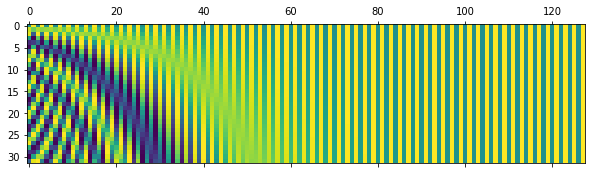

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
# ax.matshow(PositionalEmbedding(128, 32)(torch.Size([1, 32, 128]))[0,:,:].numpy())
ax.matshow(positional_encoding_matrix(10, 128, 32)[0,:,:].numpy())

In [34]:
class EncoderComponent(nn.Module):
    '''
    The individual component of encoder stack. 
    '''
    
    def __init__(self, embedding_size, n_heads, projection_size_qk, projection_size_v, n_hidden,dropout_fraction):
        super(EncoderComponent, self).__init__()
        self.mha = MultiHeadAttention(n_heads, projection_size_qk, projection_size_v, 
                                      embedding_size)
        self.fc1 = nn.Linear(embedding_size, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, embedding_size)
        self.layernorm1 = nn.LayerNorm(embedding_size)
        self.layernorm2 = nn.LayerNorm(embedding_size)
        self.dropout1 = nn.Dropout(dropout_fraction)
        self.dropout2 = nn.Dropout(dropout_fraction)
        self.dropout3 = nn.Dropout(dropout_fraction)
        
    def forward(self, inputs, pad_mask=None):
        mha0, aw = self.mha(inputs, inputs, inputs, pad_mask)
        mha = self.layernorm1(self.dropout1(mha0) + inputs)
        out = self.layernorm2(self.dropout2(self.fc2(self.dropout3(self.relu(self.fc1(mha))))) + mha)
        return out, aw

In [35]:
class EncoderBlock(nn.Module):
    '''
    The encoder stack. 
    '''
    
    def __init__(self, batch_size, vocab_size_in, embedding_size, 
                 max_in_seq_len, n_heads, projection_size_qk, projection_size_v,n_hidden, n_enc_layers, dropout_fraction):
        super(EncoderBlock, self).__init__()
        self.embedding = nn.Embedding(vocab_size_in,embedding_size, padding_idx=pad_indx)
        self.pos_encoding_matrix = positional_encoding_matrix(batch_size,embedding_size, max_in_seq_len)
        self.encoder_stack = nn.ModuleList([EncoderComponent(embedding_size, n_heads, 
                                               projection_size_qk, projection_size_v, n_hidden,dropout_fraction) for _ in torch.arange(n_enc_layers)])
        
        
        self.dropout1 = nn.Dropout(dropout_fraction)
        self.sqrt_embedding_size  = embedding_size**(0.5)
    def forward(self, inputs, pad_mask=None, return_attention_weights=False):
        

        emb = self.embedding(inputs)
        pos_enc = self.pos_encoding_matrix[:inputs.shape[0], :inputs.shape[1],:].to(inputs.device)
        x = self.dropout1(emb*self.sqrt_embedding_size + pos_enc)
        if not return_attention_weights:
            for encoder_component in self.encoder_stack:
                x,_ = encoder_component(x, pad_mask)
            return x, None
        else:
            aw_list=[]
            for encoder_component in self.encoder_stack:
                x,aw = encoder_component(x, pad_mask)
                aw_list.append(aw)
            return x, aw_list
            
            

In [36]:
class DecoderComponent(nn.Module):
    '''
    The individual component of decoder stack. 
    '''
    def __init__(self, embedding_size, n_heads, projection_size_qk, projection_size_v, n_hidden, dropout_fraction):
        super(DecoderComponent, self).__init__()
        self.mha1 = MultiHeadAttention(n_heads, projection_size_qk, projection_size_v, embedding_size)
        self.mha2 = MultiHeadAttention(n_heads, projection_size_qk, projection_size_v, embedding_size)
        self.fc1 = nn.Linear(embedding_size, n_hidden)
        self.relu = nn.GELU()#nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, embedding_size)
        self.layernorm1 = nn.LayerNorm(embedding_size)
        self.layernorm2 = nn.LayerNorm(embedding_size)
        self.dropout1 = nn.Dropout(dropout_fraction)
        self.dropout2 = nn.Dropout(dropout_fraction)
        self.dropout3 = nn.Dropout(dropout_fraction)
        self.dropout4 = nn.Dropout(dropout_fraction)
        
    def forward(self, outputs, encoder_outputs, mask, inp_pad_mask):
        mha1, aw1 = self.mha1(outputs, outputs, outputs, mask)
        mha1 = self.layernorm1(self.dropout1(mha1) + outputs)
        
        mha2, aw2 = self.mha2(mha1, encoder_outputs, encoder_outputs, inp_pad_mask)
        mha2 = self.layernorm1(self.dropout2(mha2) + mha1)
        out = self.layernorm2(self.dropout3(self.fc2(self.dropout4(self.relu(self.fc1(mha2))))) + mha2)
        return out, aw1, aw2

In [37]:
class DecoderBlock(nn.Module):
    '''
    The decoder stack. 
    '''
    
    def __init__(self, batch_size, vocab_size_out, embedding_size, max_out_seq_len, n_heads, projection_size_qk, projection_size_v, n_hidden, n_dec_layers, dropout_fraction):
        super(DecoderBlock, self).__init__()
        self.embedding = nn.Embedding(vocab_size_out,embedding_size, padding_idx=pad_indx)
        self.pos_encoding_matrix = positional_encoding_matrix(batch_size,embedding_size, max_out_seq_len)
        self.decoder_stack = nn.ModuleList([DecoderComponent(embedding_size, n_heads, 
                                               projection_size_qk, projection_size_v, n_hidden, dropout_fraction) for _ in torch.arange(n_dec_layers)])
        
        self.linear = nn.Linear(n_hidden, vocab_size_out)
        self.lsf = nn.LogSoftmax(dim=-1)
        self.dropout1 = nn.Dropout(dropout_fraction)
        self.sqrt_embedding_size  = embedding_size**(0.5)
        
    def forward(self, outputs, encoder_outputs, mask,inp_pad_mask, return_attention_weights = False):
        emb = self.embedding(outputs)
        pos_dec = self.pos_encoding_matrix[:outputs.shape[0], :outputs.shape[1],:].to(outputs.device)
        x = self.dropout1(emb*self.sqrt_embedding_size + pos_dec)
        if not return_attention_weights:
            for decoder_component in self.decoder_stack:
                x,_,_ = decoder_component(x,encoder_outputs,  mask, inp_pad_mask)
            return self.lsf(self.linear(x)), None, None
        else:
            aw_list1=[]
            aw_list2=[]
            for decoder_component in self.decoder_stack:
                x,aw1, aw2 = decoder_component(x,encoder_outputs,  mask, inp_pad_mask)
                aw_list1.append(aw1)
                aw_list2.append(aw2)
            return self.lsf(self.linear(x)), aw_list1, aw_list2

In [38]:
class TransformerModel(nn.Module):
    '''
    The transformer model as described in "Attention is all you need"
    '''
    def __init__(self, batch_size, vocab_size_in, vocab_size_out, embedding_size, max_in_seq_len, max_out_seq_len, n_heads,
                 projection_size_qk, projection_size_v,n_hidden, n_enc_layers, n_dec_layers, dropout_fraction):
        super(TransformerModel, self).__init__()
        self.encoder = EncoderBlock(batch_size, vocab_size_in, embedding_size, 
                 max_in_seq_len, n_heads, projection_size_qk, projection_size_v,n_hidden, n_enc_layers,dropout_fraction)
            
        self.decoder = DecoderBlock(batch_size, vocab_size_out, embedding_size, max_out_seq_len, n_heads,
                                    projection_size_qk, projection_size_v, n_hidden, n_dec_layers,dropout_fraction)
        self.vocab_size_out = vocab_size_out
        
        for param in self.parameters():
            if param.requires_grad:
                if param.dim()>=2:
                    torch.nn.init.xavier_uniform_(param)  
#                 else:
#                     torch.nn.init.uniform_(param)  
            
    def forward(self, inputs, outputs, return_attention_weights=False):
        
        inp_pad_mask = ((inputs.detach()==pad_indx) ).unsqueeze(1)
        encoder_outputs, aw_enc = self.encoder(inputs,inp_pad_mask)
        
        
        output_mask = torch.tril(torch.ones((outputs.shape[1], outputs.shape[1]),device=outputs.device)).bool() # mask such that the decoder doesn't see subsequent output tokens
        output_mask= ~output_mask.unsqueeze(0)
        
        out, aw_list1, aw_list2 = self.decoder(outputs, encoder_outputs, output_mask, inp_pad_mask, return_attention_weights)
        
        return out, aw_enc, aw_list1, aw_list2

# Training

In [39]:
# label smoothing + NLLLoss
class LabelSmoothingAndNLLLoss(nn.Module):
    def __init__(self, alpha =0.1, reduction = 'mean', ignore_index = -100):
        super().__init__()
        self.alpha = alpha
        self.ignore_index = ignore_index
        self.reduction = reduction

    def forward(self, log_pred_probs, true_targets):
    
        l_nll = F.nll_loss(log_pred_probs, true_targets, reduction=self.reduction, ignore_index=self.ignore_index)
        log_pred_probs = log_pred_probs.masked_fill((true_targets == self.ignore_index).unsqueeze(1), 0 ) # ignoring ignore_indx
        
        # reduction
        if self.reduction == 'mean':
            l_other = -log_pred_probs.mean()  
        elif self.reduction == 'sum':
            l_other = -log_pred_probs.sum()
        
        return (1.0-self.alpha)*l_nll + (self.alpha/log_pred_probs.shape[-1])* l_other
    

In [40]:
def eval_model(model, dataloader_valid, loss_function):
    # Eval on validation data
    model.eval()
    loss_val = 0
    
    with torch.no_grad():
        pred_sentences = []
        true_pred_sentences = []
        for batch, a in enumerate(dataloader_valid):
            inputs = a[0]
            targets = a[1]
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute predictions
            pred,*_ = model(inputs, targets[:,:-1])
            
            for row in targets:
                true_pred_sentences.append([[v_t[token]  for token in row.tolist() if token is not pad_indx]])
            
            for row in torch.argmax(pred, dim=-1):
                pred_sentences.append([v_t[token]  for token in row.tolist() if token is not pad_indx])
            
            # compute loss
            loss = loss_function(pred.view(-1,pred.shape[-1]), targets[:,1:].long().view(-1))

            # loss
            loss_val += loss.item()

        loss_val = loss_val/len(dataloader_valid)
        bleu_score = torchtext.data.metrics.bleu_score(pred_sentences,true_pred_sentences)

    return loss_val, bleu_score

In [41]:
def train_model(model, dataloader_train,loss_function, optimizer, scheduler, clip_norm):
    model.train()
    
    loss_accumulated = 0
    for batch, (inputs, targets) in tqdm(enumerate(dataloader_train), total=len(dataloader_train)):

        inputs, targets = inputs.to(device), targets.to(device)

        # zero gradients
        optimizer.zero_grad()

        pred,*_  = model(inputs, targets[:,:-1]) 

        # compute loss
        loss = loss_function(pred.view(-1,pred.shape[-1]), targets[:,1:].long().view(-1))

        # compute gradients
        loss.backward()

        # clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        # torch.nn.utils.clip_grad_value_(model.parameters(), CLIP_VAL)

        # update params
        optimizer.step()

        # lr scheduler
        scheduler.step()

        loss_accumulated += loss.item()
    loss_accumulated = loss_accumulated/len(dataloader_train)

    return loss_accumulated

## Run experiment

In [52]:
config_dict = {
    'batch_size':64,
    'vocab_size_in':len(vocab_src),
    'vocab_size_out':len(vocab_trg),
    'embedding_size':512,
    'max_in_seq_len':200, # need only for positional encoding...any number greater than the actual max_length should do
    'max_out_seq_len':250, 
    'n_heads':8,
    'projection_size_qk':64,
    'projection_size_v':64,
    'n_enc_layers':3,
    'n_dec_layers':3,
    'n_hidden':512,
    'dropout_fraction':0.1,
    'num_epochs': 50,
    'learning_rate':0.0005,
    'clip_norm': 0.5,
    'label_smoothing_alpha': 0.1,
    'dataset': 'Multi30k_de_en',
    'model_type': 'Transformer'
}

In [43]:
def model_pipeline(config= config_dict):

    with wandb.init(project="NMT", config=config_dict) as run:
        
        config = wandb.config

        # generate dataloaders
        BATCH_SIZE = config.batch_size
        SHUFFLE = True
        DROP_LAST = False
        dataloader_train  = torch.utils.data.DataLoader(dataset_train, shuffle=SHUFFLE, batch_size=BATCH_SIZE, drop_last=DROP_LAST, collate_fn=collate_by_padding, num_workers=2, pin_memory=True)
        dataloader_valid  = torch.utils.data.DataLoader(dataset_valid, shuffle=SHUFFLE, batch_size=BATCH_SIZE, drop_last=DROP_LAST, collate_fn=collate_by_padding, num_workers=2, pin_memory=True)

        # build model
        
        model = TransformerModel(config.batch_size, config.vocab_size_in, config.vocab_size_out, config.embedding_size,config.max_in_seq_len,
                                 config.max_out_seq_len, config.n_heads, config.projection_size_qk, 
                                 config.projection_size_v,config.n_hidden, config.n_enc_layers,
                                 config.n_dec_layers, config.dropout_fraction)

        # loss function
        # loss_function = nn.NLLLoss()
        loss_function = LabelSmoothingAndNLLLoss(alpha = config.label_smoothing_alpha)


        # optimizer 
        # optimizer = torch.optim.Adam(model.parameters(),lr=config.learning_rate)
        optimizer= torch.optim.Adam(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.98), eps=1e-9)

        # lr scheduler
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config.learning_rate, 
                                                        steps_per_epoch=len(dataloader_train), 
                                                        epochs=config.num_epochs, 
                                                        cycle_momentum=True, 
                                                        anneal_strategy = 'linear', 
                                                        three_phase=True, 
                                                        pct_start=0.4,
                                                        div_factor=10.0,
                                                        final_div_factor = 1000.0
                                                        )
        
        # send model to device
        model = model.to(device)

        # free memory
        gc.collect()
        torch.cuda.empty_cache()

        # suffix for checkpoints
        suffix = '_'.join([config.model_type, config.dataset, str(config.embedding_size) , 
                           str(config.batch_size),datetime.now().strftime('%b%d_%H-%M-%S') ])
        
        # wandb watch
        wandb.watch(model, loss_function, log="all", log_freq=10, log_graph=False)

        # train and eval
        min_valid_loss_until_now = 1000
        max_valid_bleu_until_now = -1000
        patience = config.early_stopping_patience
        epochs_since_last_val_best = 0
        for epoch in tqdm(range(config.num_epochs)):
            # train
            loss_train_teacher_forced = train_model(model, dataloader_train, loss_function,optimizer,scheduler, config.clip_norm)

            # eval
            loss_val, bleu_val = eval_model(model, dataloader_valid, loss_function)
            # loss_train, bleu_train = eval_model(model, dataloader_train, loss_function)

            wandb.log({"epoch": epoch, 
                    # "loss_train": loss_train, 
                    'loss_val': loss_val,
                    'loss_train_teacher_forced': loss_train_teacher_forced,
                    # 'bleu_train':bleu_train,
                    'bleu_val': bleu_val}, step=epoch)
            
            # # checkpoint
            
            torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        # 'loss_train': loss_train,
                        'loss_train_teacher_forced': loss_train_teacher_forced,
                        'loss_val':loss_val,
                        'bleu_val': bleu_val,
                        # 'bleu_train':bleu_train,
                        'config': config_dict,
                        }, 'saved_models/'+suffix+'_latest_train.pth')

            if min_valid_loss_until_now > loss_val:
                min_valid_loss_until_now = loss_val
                torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            # 'loss_train': loss_train,
                            'loss_train_teacher_forced': loss_train_teacher_forced,
                            'loss_val':loss_val,
                            'bleu_val': bleu_val,
                            # 'bleu_train':bleu_train,
                            'config': config_dict,
                            }, 'saved_models/'+suffix+'_best_val_loss.pth')
            
            if max_valid_bleu_until_now < bleu_val:
                max_valid_bleu_until_now = bleu_val
                torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            # 'loss_train': loss_train,
                            'loss_train_teacher_forced': loss_train_teacher_forced,
                            'loss_val':loss_val,
                            'bleu_val': bleu_val,
                            # 'bleu_train':bleu_train,
                            'config': config_dict,
                            }, 'saved_models/'+suffix+'_best_val_bleu.pth')

                epochs_since_last_val_best = 0
            else:
                epochs_since_last_val_best += 1

            # Early stopping

            if epochs_since_last_val_best >= patience :
                print('Early stopping triggered.')
                break

    return model, dataloader_train, dataloader_valid, suffix
        




In [ ]:
model, dataloader_train, dataloader_valid, suffix = model_pipeline(config_dict)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

epoch,19
loss_val,2.05415
loss_train_teacher_forced,0.26587
bleu_val,0.10229
_runtime,3788
_timestamp,1631011545
_step,19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss_val,█▅▃▂▂▂▁▁▁▂▃▃▄▄▅▅▆▆▆▆
loss_train_teacher_forced,█▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
bleu_val,▁▃▄▅▅▆▆▆▇▇██████████
_runtime,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇███
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇███
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


# Some translations

In [56]:
from collections import namedtuple
config = namedtuple('obj', config_dict.keys())(*config_dict.values())

dataloader_test = DataLoader(dataset_test, shuffle=False, batch_size=len(dataset_test), drop_last=False, collate_fn=collate_by_padding)
model = TransformerModel(config.batch_size, config.vocab_size_in, config.vocab_size_out, config.embedding_size,config.max_in_seq_len,
                                 config.max_out_seq_len, config.n_heads, config.projection_size_qk, 
                                 config.projection_size_v,config.n_hidden, config.n_enc_layers,
                                 config.n_dec_layers, config.dropout_fraction)
saved_model = torch.load('saved_models/Transformer_Multi30k_de_en_512_64_Sep07_07-47-50_best_val_bleu.pth',map_location='cpu')
# saved_model = torch.load('saved_models/'+suffix+'_best_val_bleu.pth',map_location='cpu')
model.load_state_dict(saved_model['model_state_dict'])

<All keys matched successfully>

In [90]:
model = model.to('cpu')
model.eval()
inputs, targets = next(iter(dataloader_test))

In [91]:
def translate(model, inputs, return_attention_weights=False):
    model.eval()
    with torch.no_grad():
        inp_pad_mask = ((inputs.detach()==pad_indx) ).unsqueeze(1)
        encoder_outputs, aw_enc = model.encoder(inputs,inp_pad_mask)

        pred = torch.tensor([[2]])
        # output_mask = None
        output_mask = torch.tril(torch.ones((pred.shape[1], pred.shape[1]),device=pred.device)).bool() # mask such that the decoder doesn't see subsequent output tokens
        output_mask= ~output_mask.unsqueeze(0)    
        
        out,*_ = model.decoder(pred, encoder_outputs, output_mask, inp_pad_mask, return_attention_weights)
    
        pred = torch.cat((pred,out[:,-1,:].argmax(-1).unsqueeze(1)), dim=-1)
    
        for i in range(50):
            out,*_ = model.decoder(pred, encoder_outputs, output_mask, inp_pad_mask, return_attention_weights)
            pred = torch.cat((pred,out[:,-1,:].argmax(-1).unsqueeze(1)), dim=-1)
            output_mask = torch.tril(torch.ones((pred.shape[1], pred.shape[1]),device=pred.device)).bool() # mask such that the decoder doesn't see subsequent output tokens
            output_mask= ~output_mask.unsqueeze(0)
        
    return pred
    


In [92]:
def beamSearch(model, inputs, beam_width=2, max_len = 50, return_attention_weights=False):
    model.eval()
    with torch.no_grad():
        inp_pad_mask = ((inputs.detach()==pad_indx) ).unsqueeze(1)
        encoder_outputs, aw_enc = model.encoder(inputs,inp_pad_mask)

        pred = torch.tensor([[2]]) # <bos> token
        # output_mask = None
        output_mask = torch.tril(torch.ones((pred.shape[1], pred.shape[1]),device=pred.device)).bool() # mask such that the decoder doesn't see subsequent output tokens
        output_mask= ~output_mask.unsqueeze(0)
        
        out,*_ = model.decoder(pred, encoder_outputs, output_mask, inp_pad_mask, return_attention_weights)

        # pred = torch.cat((pred,out[:,-1,:].argmax(-1).unsqueeze(1)), dim=-1)
        topk = torch.topk(out[:,-1,:], k=beam_width, dim=-1)

        candidate_tokens = topk.indices.squeeze(0)
        candidate_token_log_probs = topk.values.squeeze(0)

        to_do_list = []
        [to_do_list.append([candidate_tokens[i].view(1,1), candidate_token_log_probs[i]]) for i in range(beam_width)]
        done_list = []

        while to_do_list: # not empty
            to_do_list1 = to_do_list.copy()
            for pred, lp in to_do_list1:
                if torch.numel(pred) > max_len or pred[-1,-1].item() == 3: #(eos token )
                    done_list.append([pred, lp])
                    to_do_list.remove([pred, lp])
                else:
                    to_do_list.remove([pred, lp])
                    output_mask = torch.tril(torch.ones((pred.shape[1], pred.shape[1]),device=pred.device)).bool() # mask such that the decoder doesn't see subsequent output tokens
                    output_mask= ~output_mask.unsqueeze(0)
                    out,*_ = model.decoder(pred, encoder_outputs, output_mask, inp_pad_mask, return_attention_weights)
                    topk = torch.topk(out[:,-1,:], k=beam_width, dim=-1)

                    candidate_tokens = topk.indices.squeeze(0)
                    candidate_token_log_probs = topk.values.squeeze(0)

                    [to_do_list.append([torch.cat((pred,candidate_tokens[i].view(1,1)), dim=-1), lp+candidate_token_log_probs[i]]) for i in range(beam_width)]
            to_do_list = sorted(to_do_list, key=lambda x: x[1], reverse=True)[:beam_width]
            
        done_list = sorted(done_list, key=lambda x: x[1], reverse=True)[:beam_width]    
    return done_list
    


In [93]:
for _ in range(1):
    ind = torch.randint(low=0, high=len(inputs), size=(1,)).item()
    print(f'ind: {ind} \n')
    src = ' '.join([v_s[token]  for token in inputs[ind,:].tolist() if token is not pad_indx])
    print('Source: \n'+ src)
    print('\nOriginal Translation: \n'+ ' '.join([v_t[token] for token in targets[ind,:].tolist() if token is not pad_indx]))
    print('\nGreedy translation: \n'+
    ' '.join([v_t[token] for token in translate(model,inputs[ind:ind+1,:]).squeeze().tolist() if token is not pad_indx]))
    p = beamSearch(model, inputs[ind:ind+1,:], beam_width=2, max_len=50)
    for i in range(len(p)):
        print(f'\nModel translation (Beam Search): {i}\n'+
            ' '.join([v_t[token] for token in p[i][0].squeeze().tolist() if token is not pad_indx]))
    print('\n -------------------------------------------------------------------------------------------\n')

ind: 190 

Source: 
Eine Frau mit braunen Haaren sitzt auf einer Bank vor einem Café. <eos>

Original Translation: 
<bos> A woman with brown hair sitting on a bench outside a cafe. <eos>

Greedy translation: 
<bos> A woman with brown hair is sitting on a bench in front of a cafe. <eos>

Model translation (Beam Search): 0
A woman with brown hair is sitting on a bench in front of a cafe. <eos>

Model translation (Beam Search): 1
A woman with brown hair is sitting on a bench outside a cafe. <eos>

 -------------------------------------------------------------------------------------------

